## Install packages

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
# from transformers import get_linear_schedule_with_warmup
# from transformers.optimization import AdamW
import sys
from sys import platform
import re
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

## Set up GPU

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Load Dataset

In [4]:
data_path = Path('data')

In [5]:
train_df = pd.read_csv(data_path / 'train.csv')
test_df = pd.read_csv(data_path / 'test.csv')
val_df = pd.read_csv(data_path / 'val.csv')
y_val = val_df.label

print(f"train: {len(train_df)}")
print(f"test: {len(test_df)}")
print(f"val: {len(val_df)}")

train: 67349
test: 1821
val: 872


# Fine-Tuned Bert Classifier

## PyTorch DataLoader

In [6]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from src.datasets import SST2Dataset, DatasetType
from transformers import BertTokenizer

# Convert other data types to torch.Tensor
# train_labels = torch.tensor(y_train)
# val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32
MAX_LEN = 64

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create the DataLoader for our training set
# train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_data = SST2Dataset(DatasetType.TRAIN, tokenizer, max_seq_len = MAX_LEN, frac=0.01)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
# val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_data = SST2Dataset(DatasetType.VAL, tokenizer, max_seq_len = MAX_LEN, frac=0.1)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [7]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from src.datasets import SST2Dataset, DatasetType
from transformers import BertTokenizer

data2 = SST2Dataset(DatasetType.TRAIN, tokenizer, max_seq_len = MAX_LEN, leave_out_guid=0)

In [8]:
len(train_data)

673

In [9]:
len(data2)

67348

## Train

In [10]:
from transformers import AdamW, get_linear_schedule_with_warmup
from src.BertClassifier import BertClassifier

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [11]:
%%time

import src.utils as utils

utils.set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)

utils.train(bert_classifier, optimizer, scheduler, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is depr

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 22/22 [01:15<00:00,  3.41s/batch]

   1    |   20    |   0.693148   |     -      |     -     |   74.90  
   1    |   21    |   0.891681   |     -      |     -     |   0.18   
----------------------------------------------------------------------


   1    |    -    |   0.702173   |  0.690955  |   51.13   |   84.20  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 22/22 [01:20<00:00,  3.68s/batch]

   2    |   20    |   0.689775   |     -      |     -     |   80.68  
   2    |   21    |   0.622881   |     -      |     -     |   0.18   
----------------------------------------------------------------------


   2    |    -    |   0.686734   |  0.688457  |   52.17   |   90.34  
----------------------------------------------------------------------


Training complete!
CPU times: user 2min 40s, sys: 13.5 s, total: 2min 54s
Wall time: 2min 59s


In [18]:
# Save model parameters

model_params_path = Path('model_params')

now = datetime.now().strftime("%m-%d-%Y_%H%M%S")

# torch.save(bert_classifier.classifier.state_dict(), model_params_path / f"{now}-classifier")

## Evaluate

AUC: 0.6633
Accuracy: 51.72%


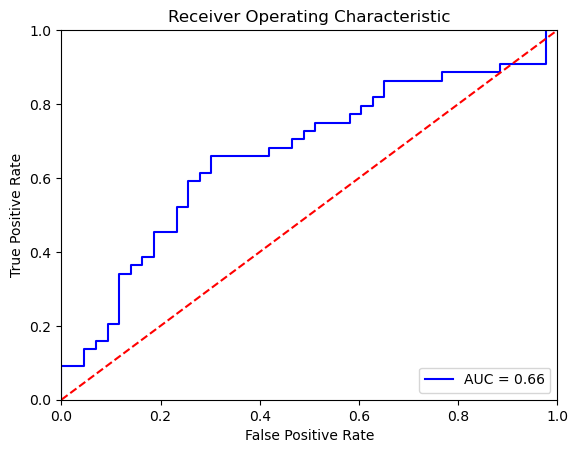

In [14]:
from src.BertClassifier import bert_predict
from src.utils import evaluate_roc

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader, device)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val[: len(probs)])

AUC: 0.6633
Accuracy: 51.72%


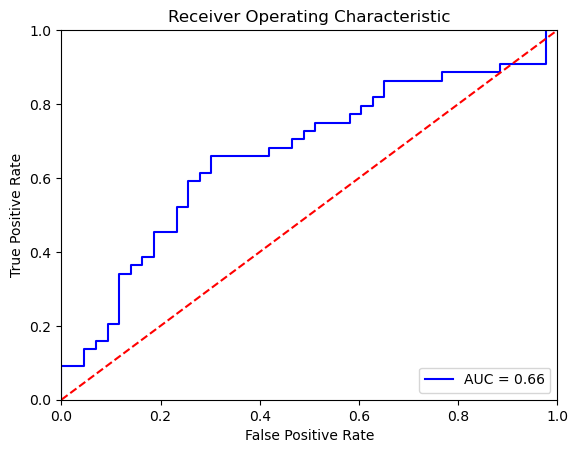

In [15]:
from src.BertClassifier import bert_predict
from src.utils import evaluate_roc

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader, device)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val[: len(probs)])

In [16]:
len(probs)

87

# Influence Function

In [17]:
# test